In [2]:
import tensorflow as tf
import skimage.io as sio
import functools
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.cross_validation import train_test_split

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())
import os
import sys
import json
import datetime
import numpy as np
import skimage.io
from imgaug import augmenters as iaa


# Import Mask RCNN
sys.path.append('/home/jimmy15923/project/monuseg/Mask_RCNN')  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize

# Path to trained weights file
COCO_WEIGHTS_PATH = "/data/jimmy15923/monuseg/maskrcnn/mask_rcnn_coco.h5"

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
# DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_LOGS_DIR = "/data/jimmy15923/cg_kidney_seg/logs"

# The dataset doesn't have a standard train/val split, so I picked
# a variety of images to surve as a validation set.
import glob
import random
idx = [os.path.basename(x) for x in glob.glob("/data/jimmy15923/cg_kidney_seg/train/*")]
random.seed(7)
random.shuffle(idx)
TRAIN_IMAGE_IDS, VAL_IMAGE_IDS = idx[:700], idx[700:]

############################################################
#  Configurations
############################################################

class KidneyConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "glomerulus"

    # number of GPU
    GPU_COUNT = 1
    
    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = (918 - len(VAL_IMAGE_IDS)) // IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, len(VAL_IMAGE_IDS) // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.90

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64 *4

    # Image mean (RGB)
#     169.82889032142856
#     117.38651496428571
#     156.06911957142856
    MEAN_PIXEL = np.array([169.82, 117.39, 156.07])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 400

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 500
    
    # Use batch normalization
    TRAIN_BN = None


class KidneyInferenceConfig(KidneyConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.75

class myKidneyDataset(utils.Dataset):

    def load_glomerulus(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.
        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("glomerulus", 1, "glomerulus")

        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
        assert subset in ["train", "val", "stage1_train", "stage1_test", "stage2_test"]

        subset_dir = "train" if subset in ["train", "val"] else subset
        dataset_dir = os.path.join(dataset_dir, subset_dir)
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
        else:
            # Get image ids from directory names
            image_ids = next(os.walk(dataset_dir))[1]
            image_ids.remove("S2016-30816_9_0")
            image_ids.remove("S2016-30816_9_1")
            if subset == "train":
                image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))


        # Add images
        for image_id in image_ids:
            self.add_image(
                "glomerulus",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "image/{}_slide.jpg".format(image_id)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "mask")
        # Read mask files from .png image
        mask = []
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith(".jpg"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "glomerulus":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)


############################################################
#  Training
############################################################

def train(model, dataset_dir, subset):
    """Train the model."""
    # Training dataset.
    dataset_train = myKidneyDataset()
    dataset_train.load_glomerulus(dataset_dir, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = myKidneyDataset()
    dataset_val.load_glomerulus(dataset_dir, "val")
    dataset_val.prepare()

    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0)),
    ])

    # *** This training schedule is an example. Update to your needs ***

    # If starting from imagenet, train heads only for a bit
    # since they have random weights
    print("Train network head")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=5,
                augmentation=augmentation,
                layers='heads')

    print("Train all layers")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                augmentation=augmentation,
                layers='all')

############################################################
#  Detection
############################################################

def detect(model, dataset_dir, subset):
    """Run detection on images in the given directory."""
    print("Running on {}".format(dataset_dir))

    # Create directory
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
    submit_dir = "submit_{:%Y%m%dT%H%M%S}".format(datetime.datetime.now())
    submit_dir = os.path.join(RESULTS_DIR, submit_dir)
    os.makedirs(submit_dir)

    # Read dataset
    dataset = NucleusDataset()
    dataset.load_nucleus(dataset_dir, subset)
    dataset.prepare()
    # Load over images
    submission = []
    for image_id in dataset.image_ids:
        # Load image and run detection
        image = dataset.load_image(image_id)
        # Detect objects
        r = model.detect([image], verbose=0)[0]
        # Encode image to RLE. Returns a string of multiple lines
        source_id = dataset.image_info[image_id]["id"]
        rle = mask_to_rle(source_id, r["masks"], r["scores"])
        submission.append(rle)
        # Save image with masks
        visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            dataset.class_names, r['scores'],
            show_bbox=False, show_mask=False,
            title="Predictions")
        plt.savefig("{}/{}.png".format(submit_dir, dataset.image_info[image_id]["id"]))

    # Save to csv file
    submission = "ImageId,EncodedPixels\n" + "\n".join(submission)
    file_path = os.path.join(submit_dir, "submit.csv")
    with open(file_path, "w") as f:
        f.write(submission)
    print("Saved to ", submit_dir)


############################################################
#  Command Line
############################################################

# if __name__ == '__main__':
#     import argparse

#     # Parse command line arguments
#     parser = argparse.ArgumentParser(
#         description='Mask R-CNN for nuclei counting and segmentation')
#     parser.add_argument("command",
#                         metavar="<command>",
#                         help="'train' or 'detect'")
#     parser.add_argument('--dataset', required=False,
#                         metavar="/path/to/dataset/",
#                         help='Root directory of the dataset')
#     parser.add_argument('--weights', required=True,
#                         metavar="/path/to/weights.h5",
#                         help="Path to weights .h5 file or 'coco'")
#     parser.add_argument('--logs', required=False,
#                         default=DEFAULT_LOGS_DIR,
#                         metavar="/path/to/logs/",
#                         help='Logs and checkpoints directory (default=logs/)')
#     parser.add_argument('--subset', required=False,
#                         metavar="Dataset sub-directory",
#                         help="Subset of dataset to run prediction on")
    



    # Configurations

config = KidneyConfig()

config.display()

# Create model

model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir='/data/jimmy15923/cg_kidney_seg/logs/')

weights_path = COCO_WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)

# model.load_weights(weights_path, by_name=True, exclude=[
#         "mrcnn_class_logits", "mrcnn_bbox_fc",
#         "mrcnn_bbox", "mrcnn_mask"])


    # Train or evaluate

# train(model, '/data/jimmy15923/cg_kidney_seg/', "train")


/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1618993340022840639
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10913166132
locality {
  bus_id: 1
  links {
  }
}
incarnation: 276994800938331186
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1"
]

Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        500
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE             

In [3]:
class myKidneyDataset(utils.Dataset):

    def load_glomerulus(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.
        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("glomerulus", 1, "glomerulus")

        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
        assert subset in ["train", "val", "stage1_train", "stage1_test", "stage2_test"]

        subset_dir = "train" if subset in ["train", "val"] else subset
        dataset_dir = os.path.join(dataset_dir, subset_dir)
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
        else:
            # Get image ids from directory names
            image_ids = next(os.walk(dataset_dir))[1]
            image_ids.remove("S2016-30816_9_0")
            image_ids.remove("S2016-30816_9_1")
            if subset == "train":
                image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))


        # Add images
        for image_id in image_ids:
            self.add_image(
                "glomerulus",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "image/{}_slide.jpg".format(image_id)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "mask")
        # Read mask files from .png image
        mask = []
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith(".jpg"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "glomerulus":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [4]:
dataset_dir = '/data/jimmy15923/cg_kidney_seg/'
dataset_train = myKidneyDataset()
dataset_train.load_glomerulus(dataset_dir, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = myKidneyDataset()
dataset_val.load_glomerulus(dataset_dir, "val")
dataset_val.prepare()


In [6]:
TRAIN_IMAGE_IDS[0]

'S2016-15757_5_3'

In [7]:
mask = dataset_train.load_mask(0)

In [13]:
mask[0].shape

(1000, 1000, 1)

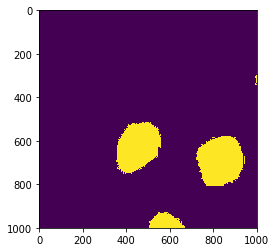

In [14]:
plt.imshow(mask[0][:,:,0])


In [ ]:
np.mean(r)

In [ ]:
import tensorflow as tf
import skimage.io as sio
import functools
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.cross_validation import train_test_split

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())
import os
import sys
import json
import datetime
import numpy as np
import skimage.io
from imgaug import augmenters as iaa


# Import Mask RCNN
sys.path.append('/home/jimmy15923/project/monuseg/Mask_RCNN')  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize

# Path to trained weights file
COCO_WEIGHTS_PATH = "/data/jimmy15923/monuseg/maskrcnn/mask_rcnn_coco.h5"

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
# DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_LOGS_DIR = "/data/jimmy15923/cg_kidney_seg/logs"

# The dataset doesn't have a standard train/val split, so I picked
# a variety of images to surve as a validation set.
import glob
import random
idx = [os.path.basename(x) for x in glob.glob("/data/jimmy15923/cg_kidney_seg/*")]
random.seed(7)
random.shuffle(idx)
TRAIN_IMAGE_IDS, VAL_IMAGE_IDS = idx[:700], idx[700:]

############################################################
#  Configurations
############################################################

class KidneyConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "glomerulus"

    # number of GPU
    GPU_COUNT = 1
    
    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 6

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = (918 - len(VAL_IMAGE_IDS)) // IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, len(VAL_IMAGE_IDS) // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.90

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64 *4

    # Image mean (RGB)
#     169.82889032142856
#     117.38651496428571
#     156.06911957142856
    MEAN_PIXEL = np.array([169.82, 117.39, 156.07])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 400

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 500
    
    # Use batch normalization
    TRAIN_BN = None


class KidneyInferenceConfig(KidneyConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.75

class myKidneyDataset(utils.Dataset):

    def load_glomerulus(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.
        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("glomerulus", 1, "glomerulus")

        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
#         assert subset in ["train", "val", "stage1_train", "stage1_test", "stage2_test"]

#         subset_dir = "stage1_train" if subset in ["train", "val"] else subset
#         dataset_dir = os.path.join(dataset_dir, subset_dir)
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
        else:
            # Get image ids from directory names
            image_ids = next(os.walk(dataset_dir))[1]
            if subset == "train":
                image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))


        # Add images
        for image_id in image_ids:
            self.add_image(
                "glomerulus",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "images/{}.jpg".format(image_id)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "mask")
        # Read mask files from .png image
        mask = []
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith(".jpg"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "glomerulus":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)


dataset_dir = '/data/jimmy15923/cg_kidney_seg/'



############################################################
#  Training
############################################################

def train(model, dataset_dir, subset):
    """Train the model."""
    # Training dataset.
    dataset_train = myKidneyDataset()
    dataset_train.load_glomerulus(dataset_dir, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = myKidneyDataset()
    dataset_val.load_glomerulus(dataset_dir, "val")
    dataset_val.prepare()

    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0)),
    ])

    # *** This training schedule is an example. Update to your needs ***

    # If starting from imagenet, train heads only for a bit
    # since they have random weights
    print("Train network head")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=5,
                augmentation=augmentation,
                layers='heads')

    print("Train all layers")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                augmentation=augmentation,
                layers='all')

############################################################
#  Detection
############################################################

def detect(model, dataset_dir, subset):
    """Run detection on images in the given directory."""
    print("Running on {}".format(dataset_dir))

    # Create directory
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
    submit_dir = "submit_{:%Y%m%dT%H%M%S}".format(datetime.datetime.now())
    submit_dir = os.path.join(RESULTS_DIR, submit_dir)
    os.makedirs(submit_dir)

    # Read dataset
    dataset = NucleusDataset()
    dataset.load_nucleus(dataset_dir, subset)
    dataset.prepare()
    # Load over images
    submission = []
    for image_id in dataset.image_ids:
        # Load image and run detection
        image = dataset.load_image(image_id)
        # Detect objects
        r = model.detect([image], verbose=0)[0]
        # Encode image to RLE. Returns a string of multiple lines
        source_id = dataset.image_info[image_id]["id"]
        rle = mask_to_rle(source_id, r["masks"], r["scores"])
        submission.append(rle)
        # Save image with masks
        visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            dataset.class_names, r['scores'],
            show_bbox=False, show_mask=False,
            title="Predictions")
        plt.savefig("{}/{}.png".format(submit_dir, dataset.image_info[image_id]["id"]))

    # Save to csv file
    submission = "ImageId,EncodedPixels\n" + "\n".join(submission)
    file_path = os.path.join(submit_dir, "submit.csv")
    with open(file_path, "w") as f:
        f.write(submission)
    print("Saved to ", submit_dir)


############################################################
#  Command Line
############################################################

if __name__ == '__main__':
    import argparse

    # Parse command line arguments
    parser = argparse.ArgumentParser(
        description='Mask R-CNN for nuclei counting and segmentation')
    parser.add_argument("command",
                        metavar="<command>",
                        help="'train' or 'detect'")
    parser.add_argument('--dataset', required=False,
                        metavar="/path/to/dataset/",
                        help='Root directory of the dataset')
    parser.add_argument('--weights', required=True,
                        metavar="/path/to/weights.h5",
                        help="Path to weights .h5 file or 'coco'")
    parser.add_argument('--logs', required=False,
                        default=DEFAULT_LOGS_DIR,
                        metavar="/path/to/logs/",
                        help='Logs and checkpoints directory (default=logs/)')
    parser.add_argument('--subset', required=False,
                        metavar="Dataset sub-directory",
                        help="Subset of dataset to run prediction on")
    args = parser.parse_args()

    # Validate arguments
    if args.command == "train":
        assert args.dataset, "Argument --dataset is required for training"
    elif args.command == "detect":
        assert args.subset, "Provide --subset to run prediction on"

    print("Weights: ", args.weights)
    print("Dataset: ", args.dataset) 
    if args.subset:
        print("Subset: ", args.subset)
    print("Logs: ", args.logs)

    # Configurations
    if args.command == "train":
        config = myNucleusConfig()
    else:
        config = myNucleusInferenceConfig()
    config.display()

    # Create model
    if args.command == "train":
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=args.logs)
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=args.logs)

    # Select weights file to load
    if args.weights.lower() == "coco":
        weights_path = COCO_WEIGHTS_PATH
        # Download weights file
        if not os.path.exists(weights_path):
            utils.download_trained_weights(weights_path)
    elif args.weights.lower() == "last":
        # Find last trained weights
        weights_path = model.find_last()
    elif args.weights.lower() == "imagenet":
        # Start from ImageNet trained weights
        weights_path = model.get_imagenet_weights()
    else:
        weights_path = args.weights

    # Load weights
    print("Loading weights ", weights_path)
    if args.weights.lower() == "coco":
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    else:
        model.load_weights(weights_path, by_name=True)

    # Train or evaluate
    if args.command == "train":
        train(model, args.dataset, args.subset)
    elif args.command == "detect":
        detect(model, args.dataset, args.subset)
    else:
        print("'{}' is not recognized. "
              "Use 'train' or 'detect'".format(args.command))